### 迁移学习

**为什么做迁移？**

源域样本和目标域样本分布有区别，目标域样本量又不够。  


#### 场景
思考我们平时建模会使用到迁移学习的一些场景：  
   
1）新开了某个消费分期的场景只有少量样本，需要用其他场景的数据进行建模；  
2）业务被迫停止3个月后项目重启，大部分训练样本比较老旧，新的训练样本又不够；   
3）在某个新的国家开展了类似国内的业务，因为国情不同，显然部分特征分布是不同的；  

#### 主要任务

**缩小边缘分布之间和条件分布下的差异。**

几个基本概念：

- Domain（域）：包括两部分：feature space（特征空间）和probability（概率）。所以当domain不同的时候，分两种情况。可能是feature space不同，也可能是feature space一样但probability不同；  

- Task（任务）：包括两部分： label space（标记空间）和objective predictive function（目标预测函数）。同理，当task不同的时候，也分两种情况。可能是label space不同，也可能是label space一样但function不同；  

- Source（源）是用于训练模型的域/任务；  

- Targe（任务）是要用前者的模型对自己的数据进行预测/分类/聚类等机器学习任务的域/任务。

通常我们说的**迁移学习**就是指将知识从**源域**迁移到**目标域**的过程。

比如我们有大量英短银渐层的图片，和少量美短起司的照片，想训练一个判别当前的猫是不是美短起司的学习器。如果我们用英短银渐层图片来作为样本，显然训练的模型是不能用来判别美短起司的，用美短起司的样本来训练，样本量又太小。这时候我们可能会使用英短银渐层来训练一个卷积神经网络，然后将这个网络的中间结构取出来作为目标模型的前半部分，然后在少量的美短起司的样本上再继续学习后面的几层网络。熟悉卷积神经网络的同学可能知道，CNN的前几层主要学习的是轮廓和局部形状等共性特征。这样通过前面的学习，我们就知道了猫咪的共性，再通过对起司的学习得到细节上的差异。

然后在提迁移学习前，首先说另一种学习方法，叫做**增量学习**。  

增量学习主要关注的是灾难性遗忘（Catastrophic forgetting），平衡新知识与旧知识之间的关系。但我们可以用它来模拟神经网络中的finetune.

Xgboost提供两种增量训练的方式：

- 一种是在当前迭代树的基础上增加新树，原树不变；  
- 另一种是当前迭代树结构不变，重新计算叶节点权重，同时也可增加新树。  

增量学习有什么用呢？

我们可以仿照神经网络中的基于模型的迁移学习，先用一部分样本训练前几棵树，然后用新的样本学习后面的树，通常我们可能用源域与目标域的混合数据训练前几棵树，以得到更好的表达能力，最后用目标域的数据训练后面几棵树。

In [11]:
import xgboost as xgb
from sklearn.datasets import load_digits # 训练数据
 
xgb_params_01 = {}
 
digits_2class = load_digits(2)
X_2class = digits_2class['data']
y_2class = digits_2class['target']
 
dtrain_2class = xgb.DMatrix(X_2class, label=y_2class)

gbdt_03 = xgb.train(xgb_params_01, dtrain_2class, num_boost_round=3) # 训练三棵树的模型

gbdt_03a = xgb.train(xgb_params_01, dtrain_2class, num_boost_round=7, xgb_model=gbdt_03) # 在原模型基础上继续训练

目前有突破的迁移学习算法基本上可以概括这几类：

#### 基于实例的迁移学习方法  （可以保留模型的解释性，本门课的重点）
- 代表有Dai等人提出的基于实例的 TrAdaBoost 迁移学习算法。当目标域中的样本被错误地分类之后，可以认为这个样本是很难分类的，因此增大这个样本的权重，在下一次的训练中这个样本所占的比重变大。如果源域中的一个样本被错误地分类了，可以认为这个样本对于目标数据是不同的，因此降低这个样本的权重，降低这个样本在分类器中所占的比重。

#### 基于特征的迁移学习方法

可以分为**基于特征选择的迁移学习方法**和**基于特征映射的迁移学习方法**。

- 基于特征选择的迁移学习方法是识别出源领域与目标领域中共有的特征表示，然后利用这些特征进行知识迁移。  

- 基于特征映射的迁移学习方法是把各个领域的数据从原始高维特征空间映射到低维特征空间，在该低维空间下，源领域数据与目标领域数据拥有相同的分布。这样就可以利用低维空间表示的有标签的源领域样本数据训练分类器，对目标测试数据进行预测。  

#### 基于模型的迁移学习方法

- 由源域学习到的模型应用到目标域上，再根据目标域学习新的模型。该方法首先针对已有标记的数据，利用决策树构建鲁棒性的行为识别模型，然后针对无标定数据，利用K-Means聚类等方法寻找最优化的标定参数。比如 TRCNN等

我们平时用的最多的就是基于实例的迁移学习方法，今天主要围绕样本的选择上做展开。

下面介绍几个统计概念

#### 联合分布（joint distribution）  

很多情况下，我们对于几个变量同时的取值有关问题感兴趣，例如我们需要知道事件“ lntellegence = high 且Grade＝ A”的概率。分析这样的事件，则需要考虑两个随机变量的联合分布（joint distribution）。下图为联合分布的一个例子。

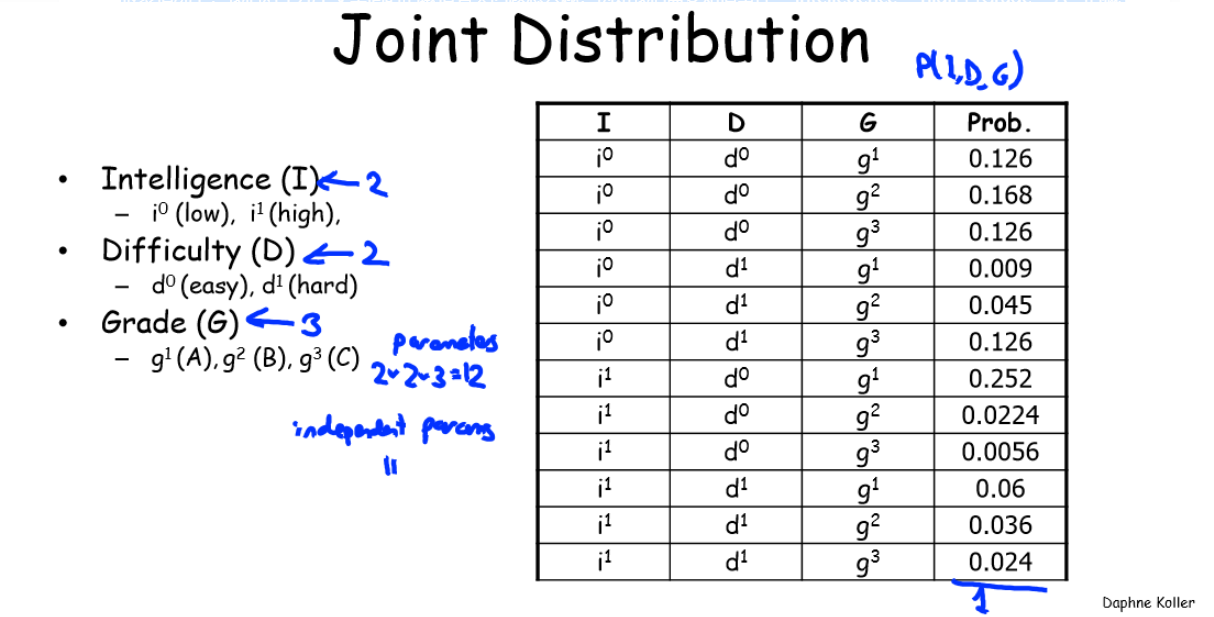

In [444]:
from IPython.display import Image
Image(filename='./image/1.png', width=600) 

上图表示了随机变量 $I,D,G$的一个联合分布，其中包含3个变量，分别是：$I$（学生智力，有0和1两个取值）、$D$（试卷难度，有0和1两个取值）、$G$（成绩等级，有1、2、3三个取值）。故而这三个离散的随机变量共有 $2×2×3=12$种联合分布状态。  

上表中我们可以读出系统取值为这 12 个联合分布状态中任一个的概率，例如：$P(I=0,D=0,G=1)=0.126.$

#### 条件分布

当对于一组随机变量，考虑其中某些变量取值特定值时，其余变量的分布是一种条件分布问题。  
可以看到，条件分布率就是在边缘分布率的基础上都加上“另一个随机变量取定某值”这个条件。  
简单来说，对于二纬离散随机变量有:   

$$P(X=x_i|Y=y_j)=\frac{P(X=x_i,Y=y_j)}{P(Y=y_j)}$$  

为在 $Y=y_j$ 条件下 X 的条件分布率. （其中$i$为固定的），也称作该联合分布在$Y$上的条件分布。   

回到 3.2 中例子来看，下图中表是概率的联合分布，表中随便去掉所有包含某个值的行，就能对分布表进行缩减。  

例如可以去掉所有 $G$ 不为 1 的行，这样就只剩下了 1、4、7、10 行，这样他们的概率之和就不为 1 了，所以需要重新标准化（Renormalization），从而推得原联合分布在 $G$ 上的条件分布4。如图为推导过程。

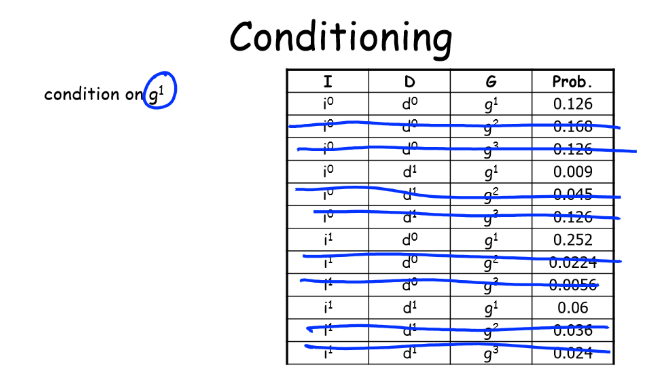

In [7]:
Image(filename='./image/2.png', width=600) 

剔除无关取值（$G$ 不为 1 的行）

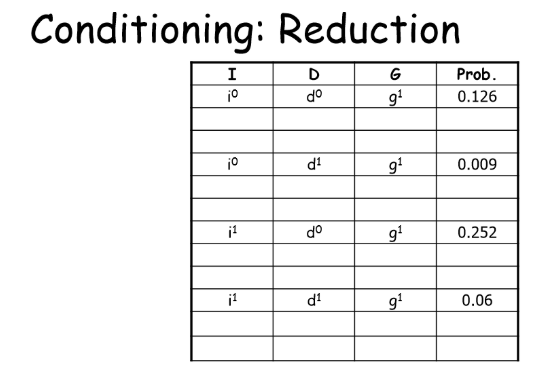

In [8]:
Image(filename='./image/3.png', width=600) 

标准化得到的值

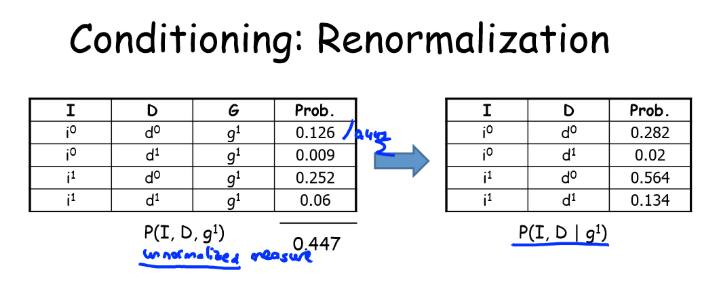

In [9]:
Image(filename='./image/4.png', width=600) 

即得到之前的联合分布在变量 $Grade(g)$上的条件分布为上图右边的表格。

反之也可以把所有含有某个值得行相加，这就是接下来要讲的边缘化（Marginalization）。由此可得上图中联合分布在变量 Ｄ 上的边缘分布如下图右表。 

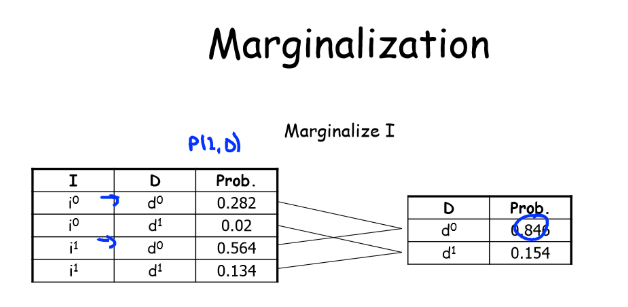

In [10]:
Image(filename='./image/5.png', width=600) 

#### 边缘分布

一旦定义了随机变量，我们就可以在能够用 $X$ 描述的事件上考虑分布。这个分布通常称为随机变量 $X$ 的边缘分布（marginal distribution) ,记为 P(X) . 这时单独只考虑 $X$ 的取值，与其它随机变量取什么值的概率无关了。   

例如，3.2 中联合分布例子里，$I$ 的边缘分布为：   

$　　P(I=0)=0.126+0.168+0.126+0.009+0.045+0.126 $  
$　　P(I=1)=0.252+0.0224+0.0056+0.06+0.036+0.024$


#### 独立同分布 

我们建模的时候一直在强调**独立同分布**，那么什么叫 **独立同分布**？  

独立同分布即指变量均服从同一种分布,并且变量之间是相互独立的（在多数情况下其实是不满足的,但往往选择忽略并不紧密的联系）。例如随机变量X1和X2，两个变量独立即指X1的出现并不影响X2，同理X2的出现并不影响X1，并且X1和X2所在的样本集具有相同的分布形状和分布参数。  

对离散随机变量具有相同的分布律，对连续随机变量则有相同的概率密度函数，有着相同的分布函数，相同的期望和方差。

**再回想一下我们的主要任务：**

**缩小边缘分布之间和条件分布下的差异。**

### 实现方法

刚刚说了我们的主要任务是 **缩小边缘分布和条件分布下的差异。**

那么如何实现这两个目标呢？  

**1）**缩小训练集与测试集的边缘分布的距离，通常的做法是 清洗训练样本，去除一些异常点或者减少他们的权重。这样可以将训练样本的分布与测试样本的分布保持一致。

**2）**如果想减少条件分布的差异呢？用决策树举例子，我们还需要在决策树划分的每一层的样本中，重复上述过程，才可以保证条件概率分布也是相近的。  

我们这里不得不介绍一下另一个Boosting的树模型--AdaBoost

这是它的迭代过程。

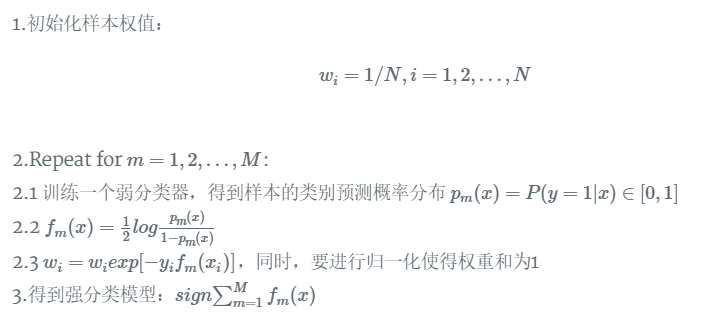

In [448]:
Image(filename='./image/6.png', width=500) 

如果不搞清楚他的原理，看Tradaboost代码可能会一脸问号。

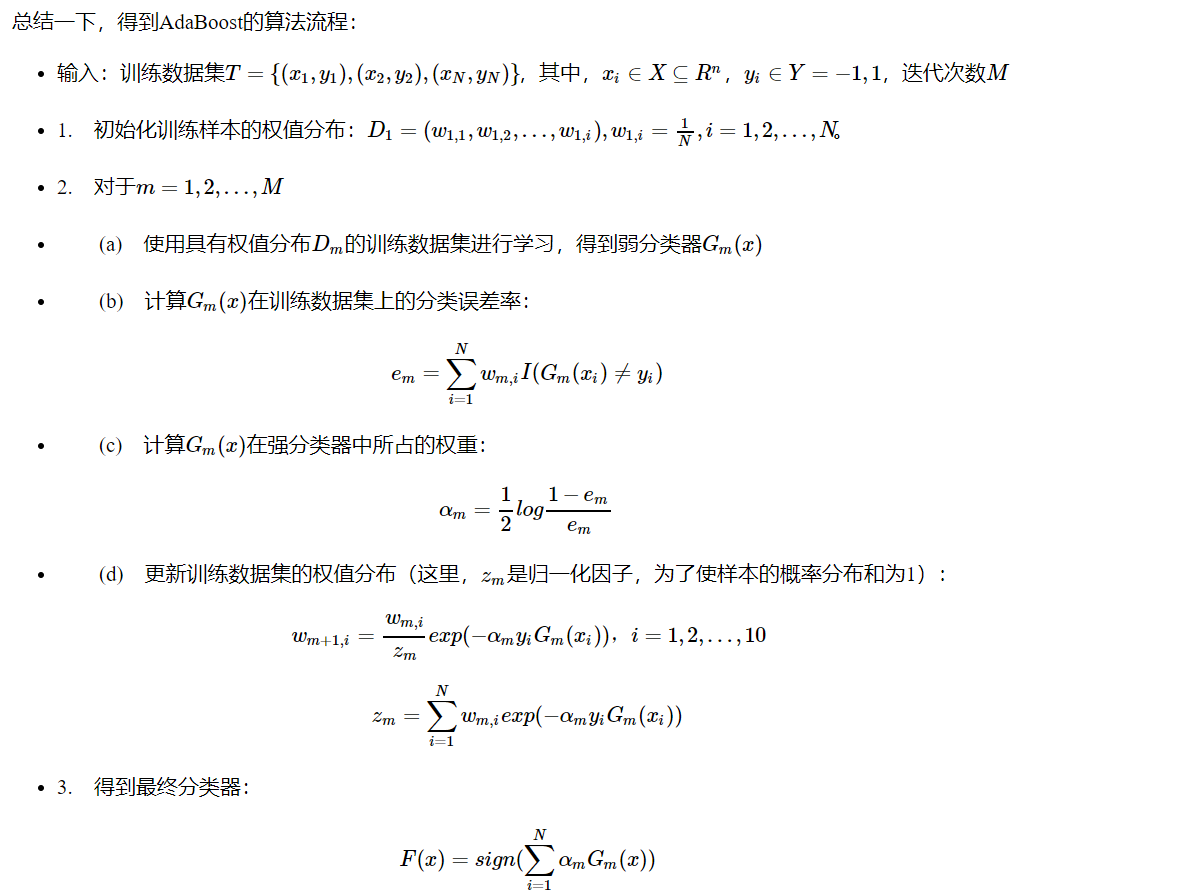

In [454]:
Image(filename='./image/7.png', width=600) 

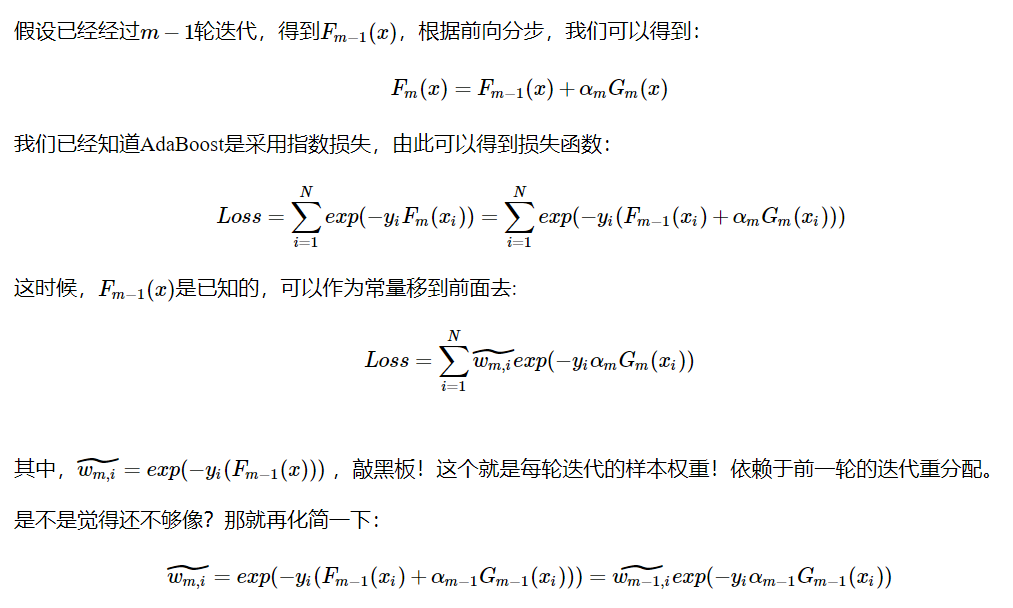

In [449]:
Image(filename='./image/8.png', width=500) 

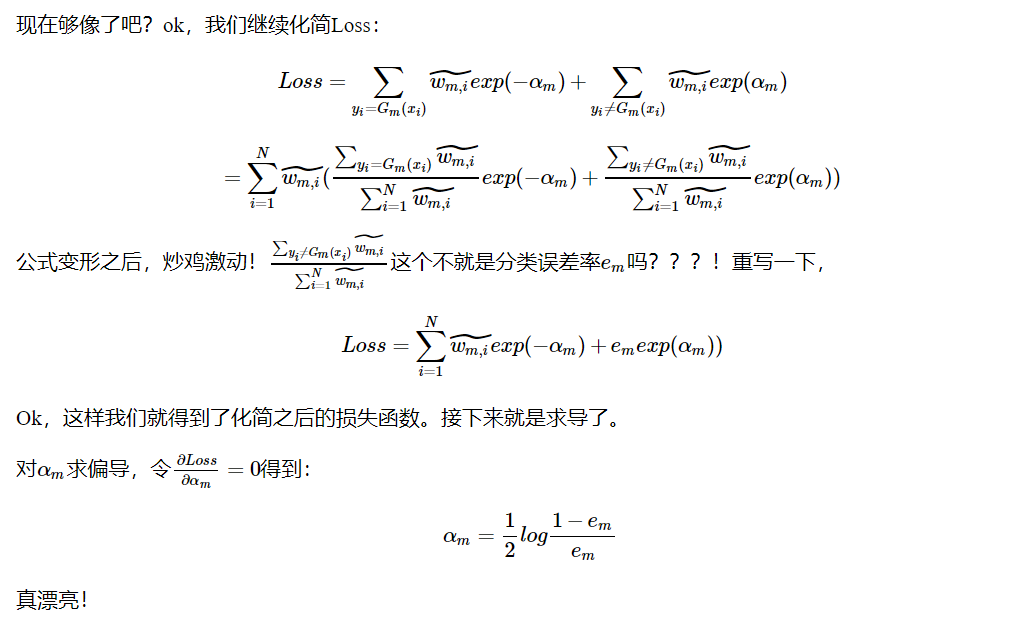

In [452]:
Image(filename='./image/9.png', width=500) 

### TrAdaboost  

#### 简述

它是Adaboost学习方法发展而来，作者是Wenyuan Dai。TrAdaboost算法是用来解决训练集和测试集分布不同的问题。在迁移学习的某些情况下，一个训练集中会包含大量的辅助训练样本和少量的源训练样本，我们会将两个不同分布的训练集放在一起训练，这种方法也称为基于实例的迁移学习方法。

#### 原理

**1）**Tradaboost是由Adaboost算法演变而来的，我们先来看Adaboost算法的基本思想：当一个训练样本被错误分类，算法就会认为这个样本是难分类的，就相应地给此样本增加样本权重，下次训练时这个样本被分错的概率就会降低。  

**2）**类似地，在一个包含源训练数据和辅助训练数据的训练集中，TrAdaboost算法也会对训练样本进行权重调整，对于源数据样本，权重调整策略跟Adaboost差不多：如果一个源训练样本被错误分类，根据这一次源样本训练时的错误率进行调整，增加权重，降低下次训练时的分类误差；对于辅助训练样本：当它们被误分类后，算法则认为它们是与目标数据很不同的，于是降低它们的权重，权重调整的依据是Hedge(b);

**3）**Tradaboost通过提升多个弱分类器，对后半（N／2～N）个弱分类器进行综合投票，得出最后的决策。

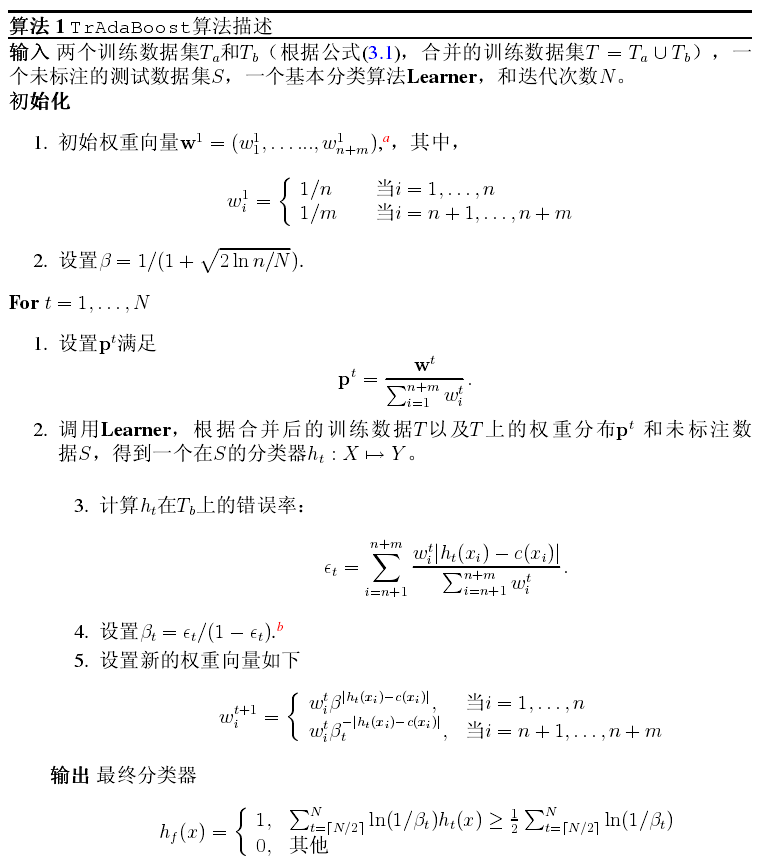

In [451]:
Image(filename='./image/10.png', width=500) 

TrAdaBoost 和 AdaBoost 主要区别在于：  

**1）**TrAdaBoost 的输入是 Ds 和 Dt 对应的两个数据集，并从 Ds 中只选取对学习任务 Tt 最有用的知识；  
**2）**TrAdaBoost 在计算模型误差时，仅考虑在 Dt 上的误差；  
**3）**TrAdaBoost 在 Ds 和 Dt 中使用不同的样本调权方式；  
**4）**TrAdaBoost 仅使用学习到的所有基学习器中，后训练的半数基学习器来预测模型效果。


样本的初始权重设置和基分类器选取比较关键。初始权重设置是较强的先验信息，而且，如果初始权重设置不当，也会影响计算稳定性。我们可以通过不同领域的样本比例，或根据不同类别样本对应的比例，或综合考虑前二者来设置初始权重。另外，基分类器的选取也会影响迭代轮数、计算稳定性和模型最终效果。  

#### 案例：跨国家跨场景迁移模型

某知名金融公司在印度新展开的小额现金贷产品，积累了少量Labled样本（约1200条），用于建模样本量显然不够，考虑到虽然国家不同，但借款用户的本质大体相似。考虑从国内大额产品的存量客户上面做迁移，首先制作四个变量。制作变量时要保证国内与印度客群都有这个字段并且字段的含义能保证一致。所以当前的问题就变成了：将知识从国内样本（源域）迁移至只有少量样本的印度客群（目标域）。

In [282]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import numpy as np
import random
import math
from sklearn.calibration import CalibratedClassifierCV

In [391]:
data = pd.read_excel('./data/tra_sample.xlsx')
data.head()

,zx_score,msg_cnt,phone_num_cnt,register_days,bad_ind,type
0,-0.322581,0.023810,0.00,0.217949,0,target
1,0.078853,0.023810,0.02,0.461538,0,target
2,0.078853,0.071429,0.00,0.217949,0,target
3,-0.128677,0.023810,0.00,0.217949,0,target
4,-0.261014,0.071429,0.05,0.217949,0,target


In [393]:
data.type.unique()

array(['target', 'origin', 'offtime'], dtype=object)

In [404]:
feature_lst = ['zx_score','msg_cnt','phone_num_cnt','register_days']

In [433]:
train = data[data.type == 'target'].reset_index().copy()
diff = data[data.type == 'origin'].reset_index().copy()
val = data[data.type == 'offtime'].reset_index().copy()

#trans_S, trans_A, label_S, label_A, test
train = train.loc[:1200]

trans_S = train[feature_lst].copy()
label_S = train['bad_ind'].copy()

trans_A = diff[feature_lst].copy()
label_A = diff['bad_ind'].copy()

val_x =  val[feature_lst].copy()
val_y = val['bad_ind'].copy()

test = val_x.copy()

train_ks :  0.48500238435860754
val_ks :  0.3887057754389137


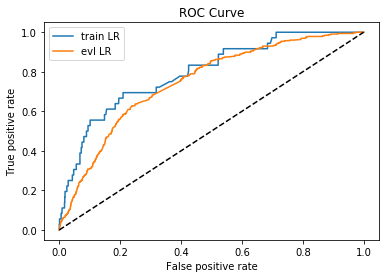

In [434]:
lr_model = LogisticRegression(C=0.1,class_weight = 'balanced',solver = 'liblinear')
lr_model.fit(trans_S,label_S)

y_pred = lr_model.predict_proba(trans_S)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(label_S,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

train_ks :  0.4910909493184976
val_ks :  0.33077621830414


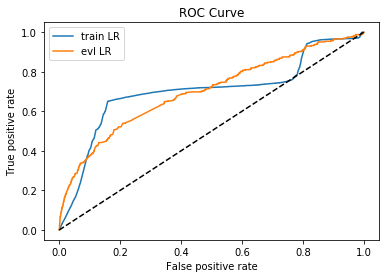

In [438]:
trans_data = np.concatenate((trans_A, trans_S), axis=0)
trans_label = np.concatenate((label_A, label_S), axis=0)

lr_model = LogisticRegression(C=0.3,class_weight = 'balanced',solver = 'liblinear')
lr_model.fit(trans_A,label_A)

y_pred = lr_model.predict_proba(trans_data)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(trans_label,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

In [440]:
import numpy as np
from sklearn import tree

#逻辑回归的学习率、权重的大小，影响整体收敛的快慢
#初始权重很重要

# H 测试样本分类结果
# TrainS 目标域样本
# TrainA 源域样本
# LabelS 目标域标签
# LabelA 源域标签
# Test  测试样本
# N 迭代次数

#计算weight
def calculate_P(weights, label):
    total = np.sum(weights)
    return np.asarray(weights / total, order='C')

#用逻辑回归作为基分类器，输出概率
def train_classify(trans_data, trans_label, test_data, P):
    clf = LogisticRegression(C=0.3,class_weight = 'balanced',solver='liblinear')
    clf.fit(trans_data, trans_label, sample_weight=P[:, 0])
    return clf.predict_proba(test_data)[:,1],clf

#计算在目标域上面的错误率
def calculate_error_rate(label_R, label_H, weight):
    total = np.sum(weight)
    return np.sum(weight[:, 0] / total * np.abs(label_R - label_H))

#根据逻辑回归输出的score的得到标签，注意这里不能用predict直接输出标签
def put_label(score_H,thred):
    new_label_H = []
    for i in score_H:
        if i <= thred:
            new_label_H.append(0)
        else:
            new_label_H.append(1)
    return new_label_H

#指定迭代次数，相当于集成模型中基模型的数量
N=500

trans_data = np.concatenate((trans_A, trans_S), axis=0)
trans_label = np.concatenate((label_A, label_S), axis=0)

row_A = trans_A.shape[0]
row_S = trans_S.shape[0]
row_T = test.shape[0]

test_data = np.concatenate((trans_data, test), axis=0)

# 初始化权重
weights_A = np.ones([row_A, 1])/row_A
weights_S = np.ones([row_S, 1])/row_S*2
weights = np.concatenate((weights_A, weights_S), axis=0)

bata = 1 / (1 + np.sqrt(2 * np.log(row_A / N)))

# 存储每次迭代的标签和bata值？
bata_T = np.zeros([1, N])  # 存每一次迭代的 error_rate / (1 - error_rate)
result_label = np.ones([row_A + row_S + row_T, N])

predict = np.zeros([row_T])

trans_data = np.asarray(trans_data, order='C')
trans_label = np.asarray(trans_label, order='C')
test_data = np.asarray(test_data, order='C')

best_ks = -1    #最优KS
best_round = -1 #最优基模型数量
best_model = -1 #最优模型

# 初始化结束

for i in range(N):
    P = calculate_P(weights, trans_label)

    result_label[:, i],model = train_classify(trans_data, trans_label,
                                        test_data, P)
    score_H = result_label[row_A:row_A + row_S, i]
    pctg = np.sum(data.bad_ind)/len(data.bad_ind)
    thred = pd.DataFrame(score_H).quantile(1-pctg)[0]
    label_H = put_label(score_H,thred)
    error_rate = calculate_error_rate(label_S, label_H,
                                      weights[row_A:row_A + row_S, :])

    if error_rate > 0.5:
        error_rate = 0.5
    if error_rate == 0:
        N = i
        break  # 防止过拟合
        # error_rate = 0.001

    bata_T[0, i] = error_rate / (1 - error_rate)

    # 调整目标域样本权重
    for j in range(row_S):
        weights[row_A + j] = weights[row_A + j] * np.power(bata_T[0, i],
                                                           (-np.abs(result_label[row_A + j, i] - label_S[j])))

    # 调整源域样本权重
    for j in range(row_A):
        weights[j] = weights[j] * np.power(bata, np.abs(result_label[j, i] - label_A[j]))

        
    y_pred = result_label[(row_A + row_S):,i]
    fpr_lr_train,tpr_lr_train,_ = roc_curve(val_y,y_pred)
    train_ks = abs(fpr_lr_train - tpr_lr_train).max()
    print('test_ks : ',train_ks,'当前第',i+1,'轮')
    
    
    if train_ks > best_ks :
        best_ks = train_ks
        best_round = i
        best_model = model

test_ks :  0.15578884442899515 当前第 1 轮
test_ks :  0.14516536326608226 当前第 2 轮
test_ks :  0.15162300261719303 当前第 3 轮
test_ks :  0.1558032631518237 当前第 4 轮
test_ks :  0.1691497396056596 当前第 5 轮
test_ks :  0.18316668667102087 当前第 6 轮
test_ks :  0.19194125890258712 当前第 7 轮
test_ks :  0.19767874150269593 当前第 8 轮
test_ks :  0.20399589573003157 当前第 9 轮
test_ks :  0.2112438369702288 当前第 10 轮
test_ks :  0.22672623287874094 当前第 11 轮
test_ks :  0.2283239832462235 当前第 12 轮
test_ks :  0.2287452437699427 当前第 13 轮
test_ks :  0.22928263346671307 当前第 14 轮
test_ks :  0.23500589219159906 当前第 15 轮
test_ks :  0.23935898255256594 当前第 16 轮
test_ks :  0.24515842669131616 当前第 17 轮
test_ks :  0.24558942959532493 当前第 18 轮
test_ks :  0.2501794546449331 当前第 19 轮
test_ks :  0.25538208056714684 当前第 20 轮
test_ks :  0.26120510126619767 当前第 21 轮
test_ks :  0.2656456782021645 当前第 22 轮
test_ks :  0.26746126819292093 当前第 23 轮
test_ks :  0.2747353190122941 当前第 24 轮
test_ks :  0.27767888179297207 当前第 25 轮
test_ks :  0.2860

test_ks :  0.39628145035205065 当前第 207 轮
test_ks :  0.39628145035205065 当前第 208 轮
test_ks :  0.39628145035205065 当前第 209 轮
test_ks :  0.39628145035205065 当前第 210 轮
test_ks :  0.39640927038144924 当前第 211 轮
test_ks :  0.39640927038144924 当前第 212 轮
test_ks :  0.39514997030522486 当前第 213 轮
test_ks :  0.39495824026112697 当前第 214 轮
test_ks :  0.3948943302464276 当前第 215 轮
test_ks :  0.3948943302464276 当前第 216 轮
test_ks :  0.39495824026112697 当前第 217 轮
test_ks :  0.3948943302464276 当前第 218 轮
test_ks :  0.394766510217029 当前第 219 轮
test_ks :  0.3947026002023297 当前第 220 轮
test_ks :  0.394766510217029 当前第 221 轮
test_ks :  0.3947026002023297 当前第 222 轮
test_ks :  0.3947026002023297 当前第 223 轮
test_ks :  0.3947026002023297 当前第 224 轮
test_ks :  0.3946386901876304 当前第 225 轮
test_ks :  0.3947026002023297 当前第 226 轮
test_ks :  0.3947026002023297 当前第 227 轮
test_ks :  0.39325157008200745 当前第 228 轮
test_ks :  0.39325157008200745 当前第 229 轮
test_ks :  0.39325157008200745 当前第 230 轮
test_ks :  0.39325157008200745

test_ks :  0.39054026564743183 当前第 411 轮
test_ks :  0.39054026564743183 当前第 412 轮
test_ks :  0.39054026564743183 当前第 413 轮
test_ks :  0.39054026564743183 当前第 414 轮
test_ks :  0.3907319956915297 当前第 415 轮
test_ks :  0.390795905706229 当前第 416 轮
test_ks :  0.390795905706229 当前第 417 轮
test_ks :  0.390795905706229 当前第 418 轮
test_ks :  0.3908598157209283 当前第 419 轮
test_ks :  0.390795905706229 当前第 420 轮
test_ks :  0.39092372573562767 当前第 421 轮
test_ks :  0.39092372573562767 当前第 422 轮
test_ks :  0.39098763575032697 当前第 423 轮
test_ks :  0.39105154576502626 当前第 424 轮
test_ks :  0.39105154576502626 当前第 425 轮
test_ks :  0.39111545577972556 当前第 426 轮
test_ks :  0.39098763575032697 当前第 427 轮
test_ks :  0.3892053647001607 当前第 428 轮
test_ks :  0.38926927471486 当前第 429 轮
test_ks :  0.38946100475895795 当前第 430 轮
test_ks :  0.38952491477365725 当前第 431 轮
test_ks :  0.38952491477365725 当前第 432 轮
test_ks :  0.38958882478835655 当前第 433 轮
test_ks :  0.38958882478835655 当前第 434 轮
test_ks :  0.38952491477365725

train_ks :  0.4629947544110634
val_ks :  0.39846160021324123


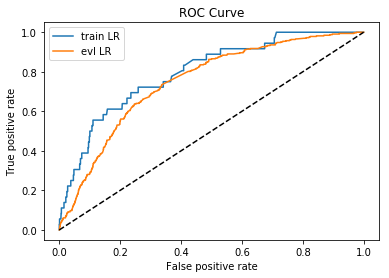

In [455]:
y_pred = best_model.predict_proba(trans_S)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(label_S,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = best_model.predict_proba(test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()